Exploring torch for the sfNorm model

Last access:  20.11.16  
Last update:  20.11.16  

In [232]:
import torch
import torch.nn as nn
from torch.utils import data as torchdata

import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import seaborn as sns

import sys
sys.path.insert(0, '../')
import helper_fcns as hf
import helper_fcns_sfBB as hfsf
import model_responses_pytorch as mrpt

import pdb


In [329]:
import autoreload as ar
ar.reload(mrpt);

In [330]:
### Helper
def _cast_as_tensor(x, device_in="cpu"):
    # needs to be float32 to work with the Hessian calculations
    return torch.tensor(x, dtype=torch.float32, device=device_in)

def _cast_as_param(x, device_in="cpu", requires_grad=True):
    # from Billy
    return torch.nn.Parameter(_cast_as_tensor(x, device_in=device_in), requires_grad=requires_grad)


In [930]:
import autoreload as ar
ar.reload(mrpt);
ar.reload(hf);

In [931]:
# Set-up the model, data, parameter, etc
cellNum = 1;
loc_str = ''
loc = '../V1_BB/structures/'

if 'BB' in loc:

    dl = hf.np_smart_load('%sdataList.npy' % loc) # for V1_BB/
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (loc, dl['unitName'][cellNum-1]));
    coreExp = cell['sfBB_core'];
    trialInf = coreExp['trial'];
    expInd = -1; # expInd doesn't apply here...

else:
    
    dl = hf.np_smart_load('%sdataList_glx_200507.npy' % loc) # for V1/
    cell = hf.np_smart_load('%s%s_sfm.npy' % (loc, dl['unitName'][cellNum-1]));
    trialInf = cell['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(loc, dl['unitName'][cellNum-1])[0];

new_params = 0; # i.e. automatically get init params or try to load?
    
excType=2
normType=1
lossType=1
lgnFrontEnd=1
newMethod = 1
respMeasure = 1; # DC [0]...or F1 [1]

if excType == 1:
    fL_name = 'fitList%s_pyt_200417' % (loc_str);
elif excType == 2:
    fL_name = 'fitList%s_pyt_200507' % (loc_str);
    
if lgnFrontEnd == 1:
    fL_name = '%s_LGN' % fL_name # implicit "a" at the end of LGN... 
elif lgnFrontEnd == 2:
    fL_name = '%s_LGNb' % fL_name

if 'BB' in loc and new_params:
    initFromCurr = 0
    # --- first, estimate prefSf, normConst if possible (TODO)                                                                                                                         
    prefSfEst = 1;
    normConst = -2;
    # --- then, set up each parameter                                                                                                                                                  
    pref_sf = float(prefSfEst) if initFromCurr==0 else curr_params[0];
    if excType == 1:
        dOrdSp = np.random.uniform(1, 3) if initFromCurr==0 else curr_params[1];
    elif excType == 2:
#         sigLow = np.random.uniform(0.1, 0.3) if initFromCurr==0 else curr_params[1];
        sigLow = np.random.uniform(0.75, 1.25) if initFromCurr==0 else curr_params[1];
        sigHigh = sigLow*np.random.uniform(1, 2) if initFromCurr==0 else curr_params[-1-np.sign(lgnFrontEnd)];                                                                                                        
    normConst = normConst if initFromCurr==0 else curr_params[2];
    respExp = np.random.uniform(1.5, 2.5) if initFromCurr==0 else curr_params[3];
    
    # easier to start with a small scalar and work up, rather than work down                                                                                                           
#     respScalar = np.random.uniform(10, 20) if initFromCurr==0 else curr_params[4];
#     respScalar = np.random.uniform(500, 750) if initFromCurr==0 else curr_params[4];
    respScalar = np.random.uniform(0.01, 0.05) if initFromCurr==0 else curr_params[4];

    noiseEarly = 1e-3 if initFromCurr==0 else curr_params[5];
#     noiseEarly = np.random.uniform(0.001, 0.01) if initFromCurr==0 else curr_params[5];
    noiseLate = 1e-1 if initFromCurr==0 else curr_params[6];
#     noiseLate = np.random.uniform(-1e1, 1e-2) if initFromCurr==0 else curr_params[6];
#     noiseLate = np.random.uniform(0.1, 1) if initFromCurr==0 else curr_params[6];
    varGain = np.random.uniform(0.1, 1) if initFromCurr==0 else curr_params[7];
    if lgnFrontEnd > 0:
        # Now, the LGN weighting                                                                                                                                                         
        mWeight = np.random.uniform(0.25, 0.75) if initFromCurr==0 else curr_params[-1];
    else:
        mWeight = -99;

    # --- finally, actually create the parameter list                                                                                                                                  
    if normType == 1:
        inhAsym = 0
        if excType == 1:
            param_list = (pref_sf, dOrdSp, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, inhAsym, mWeight);
        elif excType == 2:
            param_list = (pref_sf, sigLow, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, inhAsym, sigHigh, mWeight);
    elif normType == 2:
        normMean = np.log10(prefSfEst)
        normStd = 0.5;
        if excType == 1:
            param_list = (pref_sf, dOrdSp, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, normMean, normStd, mWeight);
        elif excType == 2:
            param_list = (pref_sf, sigLow, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, normMean, normStd, sigHigh, mWeight);
    if lgnFrontEnd == 0: # then we'll trim off the last constraint, which is mWeight bounds (and the last param, which is mWeight)                                                   
        param_list = param_list[0:-1];   
    
    fitParams = param_list;    
else:
    fitListName = hf.fitList_name(base=fL_name, fitType=normType, lossType=lossType);
    fL = hf.np_smart_load('%s%s' % (loc,fitListName))
    if 'BB' in loc:
        fitParams = [fL[cellNum-1][x]['params'] for x in ['dc', 'f1']];
    else:
        fitParams = fL[cellNum-1]['params']

In [932]:
ar.reload(mrpt);
ar.reload(hfsf);
ar.reload(hf);

In [933]:
# modTest = mrpt.sfNormMod(fitParams, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd)
if 'BB' in loc and new_params: 
    fp = np.copy(fitParams);
else:
    if respMeasure == 1:
        fp = fitParams[1];
    else:
        fp = fitParams[0] 
    
modTrain = mrpt.sfNormMod(fp, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd, newMethod=newMethod)


In [934]:
trInf, resp = mrpt.process_data(coreExp, expInd=-1, respMeasure=respMeasure)

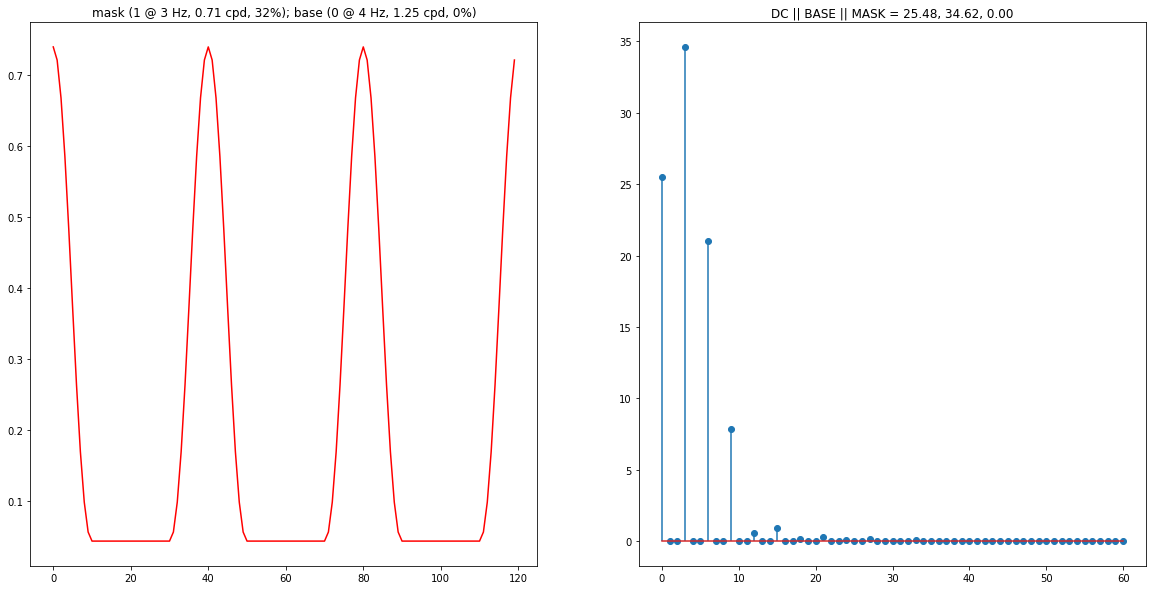

In [935]:
expInd = -1; # sfBB is -1 expInd code

# What's the trial #, associated stimulus (esp. TF)?
trNum = 0; #7 - BOTH (for cell #7) # 111 - only mask (for cell #7); # 117 - only base (for cell #7)
curr_trials = trInf['num'];
maskInd, baseInd = hf_sf.get_mask_base_inds();
maskO, baseO = trialInf['maskOn'][curr_trials[trNum]], trialInf['baseOn'][curr_trials[trNum]]
baseTf, maskTf = trInf['tf'][trNum, baseInd], trInf['tf'][trNum, maskInd]
baseSf, maskSf = trInf['sf'][trNum, baseInd], trInf['sf'][trNum, maskInd]
baseCon, maskCon = trInf['con'][trNum, baseInd], trInf['con'][trNum, maskInd]

nrow, ncol = 1, 2;

init_fit, init_psth = modTrain.forward(trInf, respMeasure=respMeasure, returnPsth=1)

# PSTH
f, ax = plt.subplots(nrow, ncol, figsize=(10*ncol, 10*nrow))
ax[0].set_title('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskO, maskTf, maskSf, 100*maskCon, 
                                                                                  baseO, baseTf, baseSf, 100*baseCon))

psth = init_psth;
ax[0].plot(psth[trNum, :].detach().numpy(), 'r')

# FFT
stimDur = hf.get_exp_params(expInd).stimDur
nFrames = len(psth)/stimDur;
tfAsInts = np.array([int(maskTf), int(baseTf)]);

amps, rel_amps, full_fourier = mrpt.spike_fft([psth], tfs=[tfAsInts], stimDur=stimDur, binWidth=1.0/nFrames)
unwrap = amps[0][trNum, :].detach().numpy();
# unwrap = amps[0][:, trNum].detach().numpy();
ax[1].stem(unwrap)
ax[1].set_title('DC || BASE || MASK = %.2f, %.2f, %.2f' % (unwrap[0], unwrap[tfAsInts[maskInd]], unwrap[tfAsInts[baseInd]]));




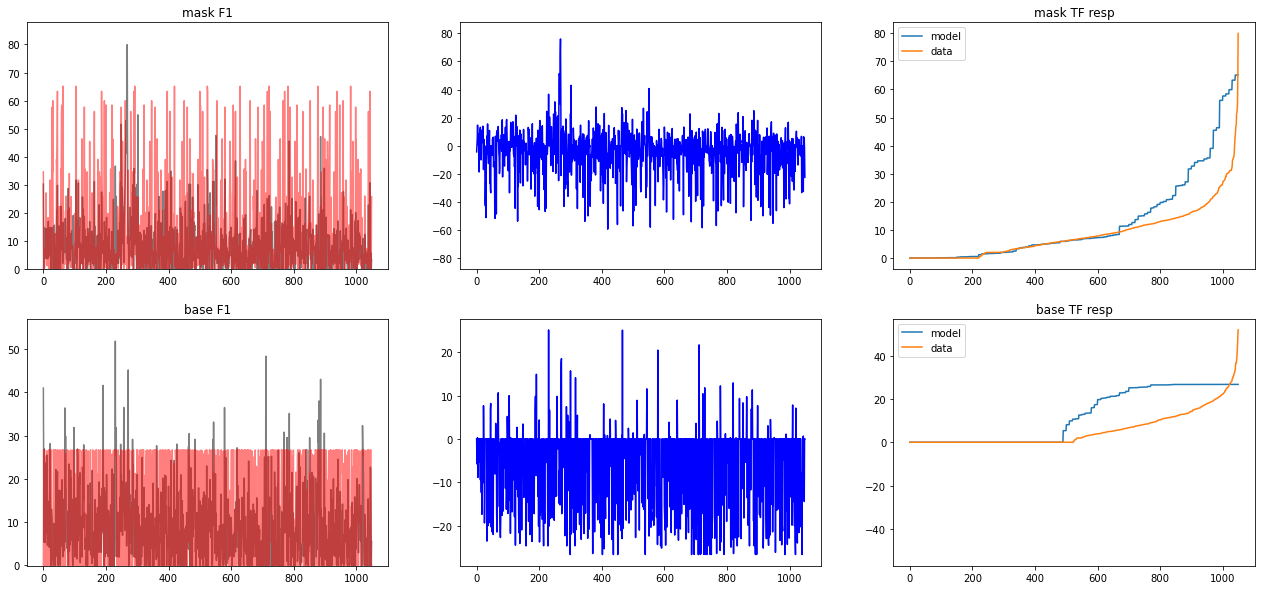

In [969]:
# let's correct the responses to have a "zero" F1 amplitude when the contrast for that component (mask or base) is 0%
respFixed = resp.copy();
maskInd, baseInd = hf_sf.get_mask_base_inds();
respFixed[trInf['con'][:,maskInd]==0, maskInd] = 0 # force F1 = 0 if con of that stim is 0
respFixed[trInf['con'][:,baseInd]==0, baseInd] = 0 # force F1 = 0 if con of that stim is 0


if respMeasure == 0:
    f, ax = plt.subplots(figsize=(20, 10))
    plt.subplot(1,2,1)

    init_as_np = init_fit[:,].detach().numpy()
    plt.plot(resp, 'k', alpha=0.5)
    # plt.plot(output[:,].detach(), 'k')
    plt.plot(init_as_np, 'r', alpha=0.5)
    max_resp = np.maximum(np.max(resp), np.max(init_as_np));
    plt.ylim([-0.1, 1.1*max_resp]);

    plt.subplot(1,2,2)
    plt.plot(resp - init_as_np, 'b')
    plt.ylim([-1.1*max_resp, 1.1*max_resp]);
    
if respMeasure == 1: # i.e. F1
    f, ax = plt.subplots(figsize=(22,10))

    plt.subplot(2,3,1) # top row will be mask
    init_as_np = init_fit.detach().numpy()
    plt.plot(respFixed[:,0], 'k', alpha=0.5)
    # plt.plot(output[:,].detach(), 'k')
    plt.plot(init_as_np[:,0], 'r', alpha=0.5)
    max_resp = np.maximum(np.max(resp[:,0]), np.max(init_as_np[:,0]));
    plt.ylim([-0.1, 1.1*max_resp]);
    plt.title('mask F1')

    plt.subplot(2,3,2)
    plt.plot(respFixed[:,0] - init_as_np[:,0], 'b')
    plt.ylim([-1.1*max_resp, 1.1*max_resp]);
    
    plt.subplot(2,3,3)
    # data vs model (just mask F1)
    plt.title('mask TF resp')
    plt.plot(sorted(init_fit[:,0]), label='model')
    plt.plot(sorted(respFixed[:,0]), label='data')
    plt.legend();
    
    plt.subplot(2,3,4) # bottom row will be base
    plt.plot(resp[:,1], 'k', alpha=0.5)
    # plt.plot(output[:,].detach(), 'k')
    plt.plot(init_as_np[:,1], 'r', alpha=0.5)
    max_resp = np.maximum(np.max(respFixed[:,1]), np.max(init_as_np[:,1]));
    plt.ylim([-0.1, 1.1*max_resp]);
    plt.title('base F1')

    plt.subplot(2,3,5)
    plt.plot(respFixed[:,1] - init_as_np[:,1], 'b')
    
    plt.subplot(2,3,6)
    # data vs model (just base F1)
    plt.title('base TF resp')
    plt.plot(sorted(init_fit[:,1]), label='model')
    plt.plot(sorted(respFixed[:,1]), label='data')
    plt.legend();


    plt.ylim([-1.1*max_resp, 1.1*max_resp]);

In [999]:
# test...
init_mask = init_as_np[:,0]
init_base = init_as_np[:,1]
val_trials = trInf['num'];

_, mod, _, modAll = hf_sf.get_mask_resp(coreExp, withBase=0, maskF1=1, f1_base=init_base, f1_mask=init_mask, val_trials=val_trials, returnByTr=1)
_, dat, _, datAll = hf_sf.get_mask_resp(coreExp, withBase=0, maskF1=1, f1_mask=coreExp['f1_mask'], returnByTr=1)

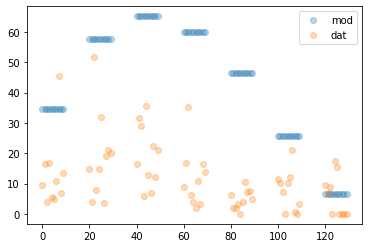

In [1024]:
# plt.plot(sorted(mod[:,:,0].flatten()))
# plt.plot(sorted(dat[:,:,0].flatten()))

# plt.figure(figsize=(20, 5))
# plt.plot(modAll.flatten(), 'o', label='mod', alpha=0.3)
# plt.plot(datAll.flatten(), 'o', label='dat', alpha=0.3)
# plt.legend()

# plt.figure(figsize=(20, 5))
ind = 6
plt.plot(modAll[ind,:,:].flatten(), 'o', label='mod', alpha=0.3)
plt.plot(datAll[ind,:,:].flatten(), 'o', label='dat', alpha=0.3)
plt.legend()

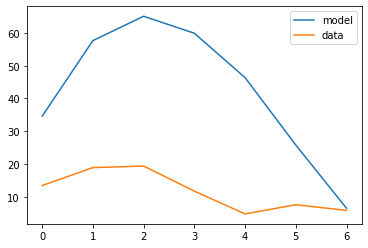

In [1015]:
ind = 6
plt.plot(ooh[ind,:,0], label='model')
plt.plot(og[ind,:,0], label='data')
plt.legend()


# ind = 0
# for ind in range(7):
#     plt.plot(ooh[ind,:,0], label='model')
#     plt.plot(og[ind,:,0], label='data')
#     plt.legend()
    
# for ind in range(7):
# #     plt.plot(ooh[:,ind,0], label='model')
#     plt.plot(og[:,ind,0], label='data')
#     plt.legend()

In [952]:
ooh.shape

(7, 7, 2)

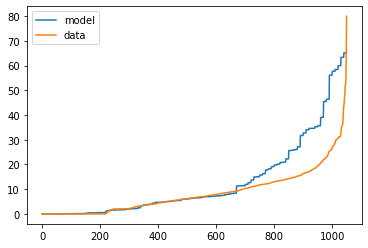

In [937]:
whichInd = 0;
plt.plot(sorted(init_as_np[:,whichInd]), label='model')
plt.plot(sorted(respFixed[:,whichInd]), label='data')
plt.legend()

In [938]:
prms = modTrain.named_parameters()
[print(x, '\n') for x in prms];

('mWeight', Parameter containing:
tensor(0.0506, requires_grad=True)) 

('prefSf', Parameter containing:
tensor(0.9935, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(1.1735, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(1.8425, requires_grad=True)) 

('sigma', Parameter containing:
tensor(-2.1082, requires_grad=True)) 

('respExp', Parameter containing:
tensor(2.1775, requires_grad=True)) 

('scale', Parameter containing:
tensor(0.0846, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0.0078, requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(0.0438, requires_grad=True)) 



In [939]:
### Now, the optimization
# - what to specify...
model = modTrain; # what's our model?

learning_rate = 0.001;
training_parameters = [p for p in model.parameters() if p.requires_grad]
max_epochs = 200;
lossType = 1;
batch_size = 200;

# --- data wrapping
dw = mrpt.dataWrapper(coreExp, respMeasure=respMeasure)
dataloader = torchdata.DataLoader(dw, batch_size)

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(trInf);
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for bb, (feature, target) in enumerate(dataloader):
        predictions = model.forward(feature, respMeasure=respMeasure, returnPsth=0)

        if respMeasure == 1:
            target['resp'][target['maskCon']==0,0] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            target['resp'][target['baseCon']==0,1] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            predictions[target['maskCon']==0,0] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            predictions[target['baseCon']==0,1] = 1e-6 # force F1 ~= 0 if con of that stim is 0
#             target = target['resp'][:,1] # let's ONLY fit the mask responses...
            target = target['resp'].flatten();
        if respMeasure == 0:
            target = target['resp'].flatten(); # since it's [nTr, 1], just make it [nTr]

#         predictions = predictions[:,0]; # since it's [nTr, 1], just make it [nTr]
        predictions = predictions.flatten(); # since it's [nTr, 1], just make it [nTr]
        loss_curr = mrpt.loss_sfNormMod(predictions, target, lossType) #model.lossType)

        if np.mod(t,100)==0 and bb==0:
            print('\n****** STEP %d *********' % t)
            prms = model.named_parameters()
            [print(x, '\n') for x in prms];
            print(loss_curr.item())
            print(loss_curr.grad)

        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, 0))

#         loss_curr.backward()
        loss_curr.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    model.train()


../model_responses_pytorch.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)



****** STEP 0 *********
('mWeight', Parameter containing:
tensor(0.0506, requires_grad=True)) 

('prefSf', Parameter containing:
tensor(0.9935, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(1.1735, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(1.8425, requires_grad=True)) 

('sigma', Parameter containing:
tensor(-2.1082, requires_grad=True)) 

('respExp', Parameter containing:
tensor(2.1775, requires_grad=True)) 

('scale', Parameter containing:
tensor(0.0846, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0.0078, requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(0.0438, requires_grad=True)) 

2.9724810123443604
None

****** STEP 100 *********
('mWeight', Parameter containing:
tensor(0.0729, requires_grad=True)) 

('prefSf', Parameter containing:
tensor(0.9231, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(1.3064, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(2.0086, requires_grad

In [940]:
# plt.plot(loss_history);

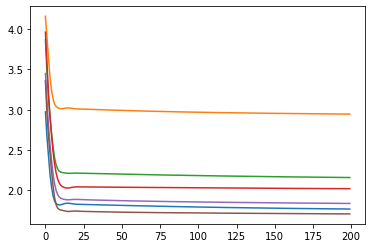

In [941]:
# final?
plt.plot(loss_history);

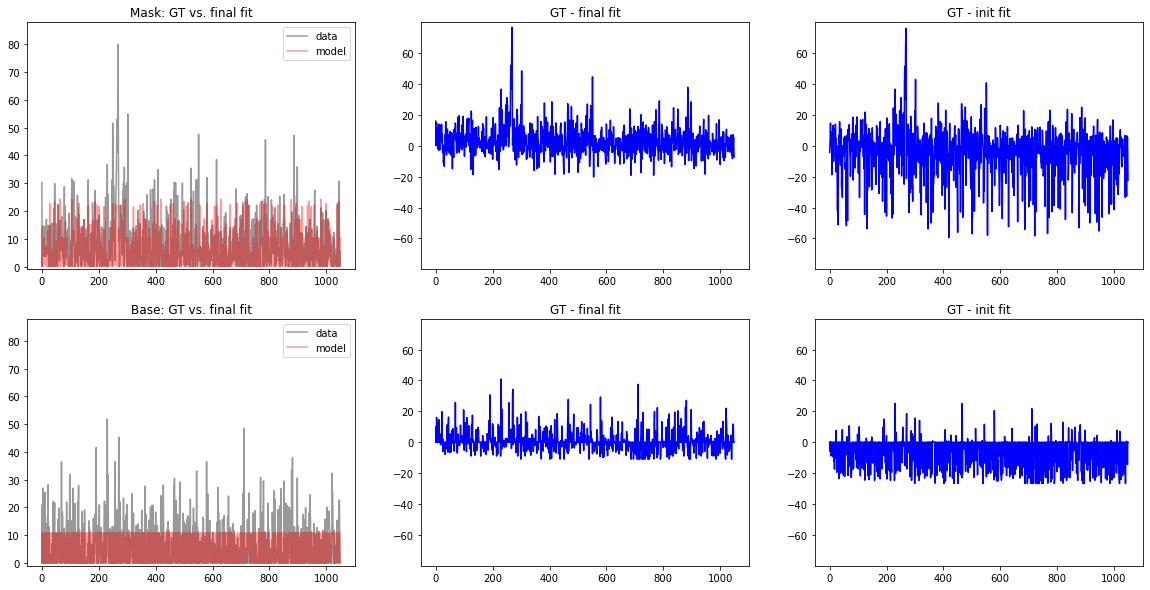

In [942]:
final_fit = model.forward(trInf, respMeasure=respMeasure, returnPsth=0)
final_fit = final_fit.detach().numpy();

f, ax = plt.subplots(figsize=(20, 10))

if respMeasure == 0:
    resp = resp.squeeze()

max_resp = np.maximum(np.max(resp), np.max(final_fit));

if respMeasure == 0:
    plt.subplot(1,3,1)
    plt.plot(resp, 'k', label='data')
    plt.plot(final_fit, 'r', label='model')
    plt.ylim([-1, 1.1*max_resp]);
    plt.title('GT vs. final fit');
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(resp - final_fit, 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - final fit');

    plt.subplot(1,3,3)
    plt.plot(resp - init_as_np, 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - init fit');

elif respMeasure == 1:
    # Top row is mask
    plt.subplot(2,3,1)
    plt.plot(respFixed[:,0], 'k', label='data', alpha=0.4)
    plt.plot(final_fit[:,0], 'r', label='model', alpha=0.4)
    plt.ylim([-1, 1.1*max_resp]);
    plt.title('Mask: GT vs. final fit');
    plt.legend()

    plt.subplot(2,3,2)
    plt.plot(respFixed[:,0] - final_fit[:,0], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - final fit');

    plt.subplot(2,3,3)
    plt.plot(respFixed[:,0] - init_as_np[:,0], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - init fit');

    # Bottom row is base
    plt.subplot(2,3,4)
    plt.plot(respFixed[:,1], 'k', label='data', alpha=0.4)
    plt.plot(final_fit[:,1], 'r', label='model', alpha=0.4)
    plt.ylim([-1, 1.1*max_resp]);
    plt.title('Base: GT vs. final fit');
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(respFixed[:,1] - final_fit[:,1], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - final fit');

    plt.subplot(2,3,6)
    plt.plot(respFixed[:,1] - init_as_np[:,1], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - init fit');

In [943]:
# get out the parameters...
# training_parameters = [p for p in model.parameters() if p.requires_grad]
prms = model.named_parameters()
[print(x, '\n') for x in prms];

('mWeight', Parameter containing:
tensor(0.1327, requires_grad=True)) 

('prefSf', Parameter containing:
tensor(0.9419, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(1.4477, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(2.2591, requires_grad=True)) 

('sigma', Parameter containing:
tensor(-1.8954, requires_grad=True)) 

('respExp', Parameter containing:
tensor(2.1622, requires_grad=True)) 

('scale', Parameter containing:
tensor(0.0259, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0.0214, requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(0.0467, requires_grad=True)) 



In [944]:
import helper_fcns_sfBB as hf_sf
maskInd, baseInd = hf_sf.get_mask_base_inds()

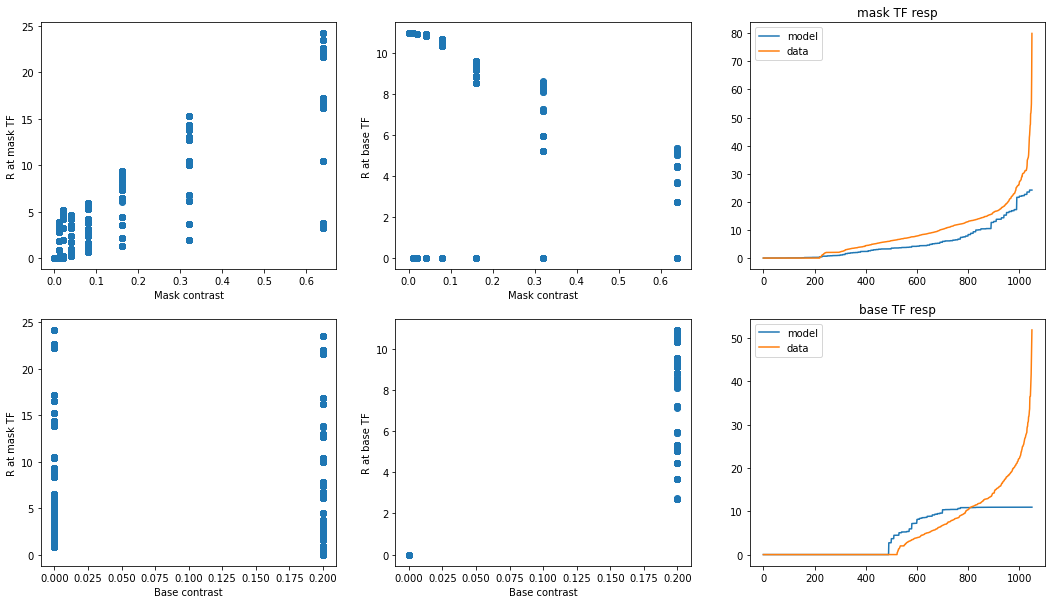

In [945]:
nRow = 2; nCol =3;
f, ax = plt.subplots(nRow,nCol,figsize=(6*nCol,5*nRow));

# mask by mask
ax[0,0].plot(trInf['con'][:, maskInd], final_fit[:, maskInd], 'o')
ax[0,0].set_xlabel('Mask contrast');
ax[0,0].set_ylabel('R at mask TF');
# mask by base
ax[0,1].plot(trInf['con'][:, maskInd], final_fit[:, baseInd], 'o')
ax[0,1].set_xlabel('Mask contrast');
ax[0,1].set_ylabel('R at base TF');
# data vs model (just mask F1)
ax[0,2].set_title('mask TF resp')
ax[0,2].plot(sorted(final_fit[:,maskInd]), label='model')
ax[0,2].plot(sorted(respFixed[:,maskInd]), label='data')
ax[0,2].legend();
# base by mask
ax[1,0].plot(trInf['con'][:, baseInd], final_fit[:, maskInd], 'o')
ax[1,0].set_xlabel('Base contrast');
ax[1,0].set_ylabel('R at mask TF');
# base by base
ax[1,1].plot(trInf['con'][:, baseInd], final_fit[:, baseInd], 'o')
ax[1,1].set_xlabel('Base contrast');
ax[1,1].set_ylabel('R at base TF');
# data vs model (just mask F1)
ax[1,2].set_title('base TF resp')
ax[1,2].plot(sorted(final_fit[:,baseInd]), label='model')
ax[1,2].plot(sorted(respFixed[:,baseInd]), label='data')
ax[1,2].legend();


In [786]:
ar.reload(mrpt);
ar.reload(hfsf);
ar.reload(hf);

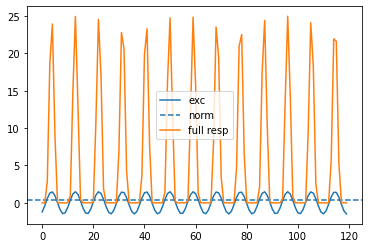

In [787]:
############
# DEBUGGING - use the debug flag in model.forward, be sure to save lexc, linh, sigmaFilt = modTrain.forward(...)
############
modTrain = mrpt.sfNormMod(fp, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd, newMethod=newMethod)
model = modTrain; # what's our model?

lexc, linh, sigmaFilt = model.forward(trInf, respMeasure=respMeasure, debug=1)

lexc_np = lexc.detach().numpy()
linh_np = linh.detach().numpy()

# plt.plot(lexc_np[])
early_noise = modTrain.noiseEarly.detach().numpy()
sigma_filt = sigmaFilt.detach().numpy()
respExp = modTrain.respExp.detach().numpy()

numer = early_noise + lexc_np
denom = np.sqrt(sigma_filt + np.square(linh_np))
full = np.transpose(np.power(np.maximum(np.divide(numer, denom), 1e-10), respExp))

spect, amps, _ = mrpt.spike_fft(mrpt._cast_as_tensor([full]), tfs=[[12,13]], stimDur=1)
spect = spect[0].detach().numpy();
amps = amps[0].detach().numpy();

# # then with no norm...
noNorm = np.transpose(np.power(np.maximum(numer, 1e-10), respExp));
spectNN, ampsNN, _ = mrpt.spike_fft(mrpt._cast_as_tensor([noNorm]), tfs=[[12,13]], stimDur=1)
spectNN = spectNN[0].detach().numpy();
ampsNN = ampsNN[0].detach().numpy();

######## plotting

trNum = 1
plt.plot(numer[:,trNum], label='exc')
plt.axhline(denom[trNum], linestyle='--', label='norm')
plt.plot(full[trNum,:], label='full resp')
plt.legend();

# ----------- separate plot

# plt.subplot(1,2,1)
# plt.plot(amps)
# plt.subplot(1,2,2)
# plt.plot(ampsNN)

# ----------- separate plot

# plt.semilogy(amps)
# plt.ylim([1e0, 1e2])
# ----------- separate plot

# plt.semilogy(amps)
# plt.ylim([1e0, 1e2])

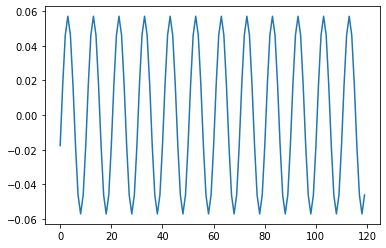

In [73]:
plt.plot(lexc[:,10].detach().numpy())

In [68]:
lexc.shape

torch.Size([120, 1050])

### original/dumb

In [ ]:
# testing flexible_Gauss
# prefSf = 1;
# sigLow = 0.9;
# sigHigh = 0.4;
# testMod = sfNormMod(modParams=[prefSf, sigLow, sigHigh])
# trainMod = sfNormMod(modParams=[prefSf*3, sigLow, sigLow])

# testing DiffOfGauss
# prefSf, gain, gainS, sfS = 3, 1, 0.3, 0.3;
# testMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])
# trainMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])

# gain_c, gain_s, r_c, r_s = 100, 10, 0.5, 0.9;
# testMod = sfNormMod(modParams=[gain_c, gain_s, r_c, r_s])
# trainMod = sfNormMod(modParams=[gain_c, gain_s, 2*r_c, r_s])


In [ ]:
### Simple example -- can we recover the original parameters with some added noise...
sfs_data = np.geomspace(0.3, 10.0, 11);
gt_resp = testMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();
# gt_detach = [x.detach().numpy() for x in gt_resp];
sfs_resp = np.clip(np.array([np.random.normal(x, scale=0.01*x) for x in gt_resp]), a_min=1e-4, a_max=None)

init_resp = trainMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();

plt.semilogx(sfs_data, init_resp, 'k', label='init_guess');
plt.semilogx(sfs_data, gt_resp, 'r');
plt.semilogx(sfs_data, sfs_resp, 'ro')
plt.title('data to fit');
plt.legend();

In [ ]:
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 2;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 4;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

In [ ]:
### Now, the optimization
# - what to specify...
model = trainMod; # what's our model?

learning_rate = 0.001;
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 3;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 1000;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
full_data = dataWrapper(sfs_data, sfs_resp)
dataloader = torchdata.DataLoader(full_data, batch_size)
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(_cast_as_tensor(sfs_data));
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for i, (features, target) in enumerate(dataloader):
    
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);

        predictions = model(features)
        loss_curr = loss_sfNormMod(predictions, target, model.lossType)
        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, i))
        loss_curr.backward()
        optimizer.step()

    model.eval()
    model.train()


In [ ]:
plt.semilogx(sfs_data, first_pred.detach().numpy(), 'k--', label='initial guess')
plt.semilogx(sfs_data, sfs_resp, 'ro', label='target');
sfs_full = np.geomspace(sfs_data[0], sfs_data[-1], 100);
plt.semilogx(sfs_full, model(_cast_as_tensor(sfs_full)).detach().numpy(), 'k', label='final');
plt.legend()

In [ ]:
plt.plot(np.sum(loss_history, axis=1))

In [ ]:
out_parameters = [p for p in model.parameters() if p.requires_grad]


In [ ]:
out_parameters

In [ ]:
og_pms = [prefSf, gain, gainS, sfS]

In [ ]:
og_pms